# Import Libraries!

In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons==0.9.1
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

     |████████████████████████████████| 1.0 MB 858 kB/s eta 0:00:01
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.12.1
    Uninstalling tensorflow-addons-0.12.1:
      Successfully uninstalled tensorflow-addons-0.12.1


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Data Presentation!

In [2]:
# Add an Additional Column, "Mapping to the Type":

df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

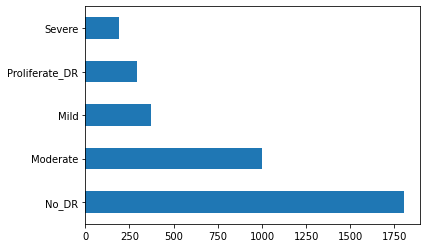

In [3]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

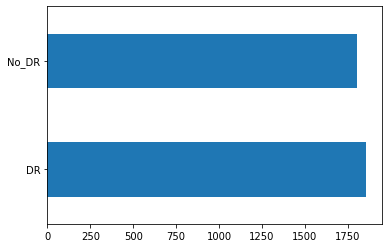

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

# Splitting Data!

In [5]:
# Split into Stratified Train, Val, and Test Sets:

train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [6]:
# Create Working Directories for train/val/test:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [7]:
# Copy Images to respective working directory:

src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test: 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


# Building the model - 8 Layer CNN!

In [9]:
model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=2, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
81/81 [==============================] - 21s 127ms/step - loss: 0.8582 - acc: 0.5412 - auc: 0.6255 - f1_score: 0.4438 - cohen_kappa: 0.1191 - val_loss: 0.6956 - val_acc: 0.5073 - val_auc: 0.5907 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 9s 114ms/step - loss: 0.4765 - acc: 0.7943 - auc: 0.8691 - f1_score: 0.7898 - cohen_kappa: 0.5935 - val_loss: 0.7094 - val_acc: 0.5073 - val_auc: 0.5735 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 9s 105ms/step - loss: 0.3761 - acc: 0.8516 - auc: 0.9212 - f1_score: 0.8506 - cohen_kappa: 0.7033 - val_loss: 0.7519 - val_acc: 0.5073 - val_auc: 0.5067 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 4/50
81/81 [==============================] - 8s 102ms/step - loss: 0.3310 - acc: 0.8686 - auc: 0.9391 - f1_score: 0.8680 - cohen_kappa: 0.7373 - val_loss: 0.7929 - val_acc: 0.5073 - val_auc: 0.5782 - val_f1_score: 0.34

# Testing Accuracy!

In [10]:
acc = model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc[1])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 1s 76ms/step - loss: 0.1724 - acc: 0.9545 - auc: 0.9718 - f1_score: 0.9545 - cohen_kappa: 0.9091
Accuracy:  0.9545454382896423


# Plotting!

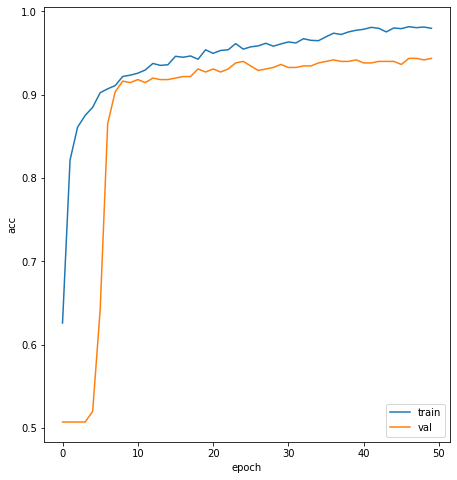

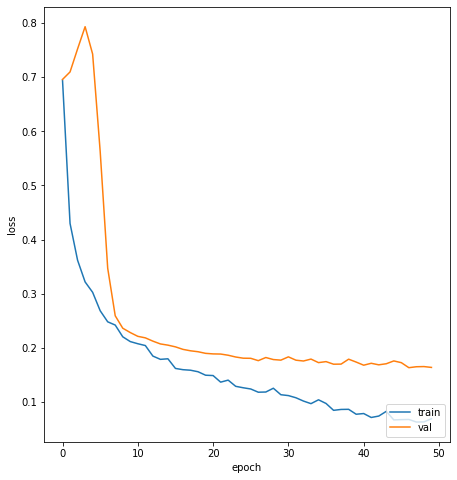

In [14]:
plt.figure(figsize=(16, 8)) 
plt.subplot(1,2,1) 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


plt.figure(figsize=(16, 8))
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
